In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import TimeSeriesSplit, KFold

In [2]:
PAMAP_PARQUET  = '../../data/features/pamapv3_perminute.parquet'
pamap = pd.read_parquet(PAMAP_PARQUET)
pamap.head()

,Subject,Minute,1,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,44_y,45_y,46_y,47_y,48_y,49_y,50_y,51_y,52_y,53_y
0,101,1970-01-01 00:00:00,1,103.764706,30.511359,-0.467062,6.265318,5.465505,-0.483229,6.248837,...,0.058981,0.057292,0.225032,563.078580,1784.485700,513.393483,0.000000,0.000000,0.000000,0.000000
1,102,1970-01-01 00:00:00,1,96.000000,33.442448,-6.768829,6.496763,2.767657,-6.649790,6.491674,...,0.001025,0.000728,0.000894,0.095017,1.481456,0.125630,0.000017,0.524832,0.006168,0.378305
2,109,1970-01-01 00:00:00,24,141.787879,24.984961,-1.589191,8.863400,-0.883374,-1.704526,8.931722,...,2.705988,0.865812,3.224218,36.309047,106.770425,22.461778,0.001960,0.013628,0.006191,0.005531
3,106,1970-01-01 00:00:00,10,90.523810,29.049495,-5.828295,3.043317,4.503328,-5.908563,3.105153,...,0.327989,0.105666,0.362653,41.011081,374.438352,65.736895,0.014858,0.009947,0.082508,0.003394
4,108,1970-01-01 00:01:00,1,81.261411,33.844712,3.590086,-2.531619,5.914757,3.685290,-2.570360,...,0.130223,0.021128,0.068750,42.876699,150.364432,293.398801,0.011035,0.112541,0.239806,0.049005


In [5]:
cluster_mapping = {
    0: [1, 2, 3, 4, 7, 12, 13],
    1: [10, 11],
    2: [5, 6, 16, 17, 18, 19, 20, 24]
}

pamap['cluster'] = pamap['1'].map({value: key for key, values in cluster_mapping.items() for value in values})
pamap = pamap[pamap['1'] != 9]
pamap['cluster'] = pamap['cluster'].astype(int)
# pamap = pamap.drop(columns=[1]) # drop activity ID column
pamap.head()

/var/folders/dk/zhw4_3kn6cb029559dwjrmt40000gn/T/ipykernel_87723/235696585.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pamap['cluster'] = pamap['cluster'].astype(int)


,Subject,Minute,1,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,45_y,46_y,47_y,48_y,49_y,50_y,51_y,52_y,53_y,cluster
0,101,1970-01-01 00:00:00,1,103.764706,30.511359,-0.467062,6.265318,5.465505,-0.483229,6.248837,...,0.057292,0.225032,563.078580,1784.485700,513.393483,0.000000,0.000000,0.000000,0.000000,0
1,102,1970-01-01 00:00:00,1,96.000000,33.442448,-6.768829,6.496763,2.767657,-6.649790,6.491674,...,0.000728,0.000894,0.095017,1.481456,0.125630,0.000017,0.524832,0.006168,0.378305,0
2,109,1970-01-01 00:00:00,24,141.787879,24.984961,-1.589191,8.863400,-0.883374,-1.704526,8.931722,...,0.865812,3.224218,36.309047,106.770425,22.461778,0.001960,0.013628,0.006191,0.005531,2
3,106,1970-01-01 00:00:00,10,90.523810,29.049495,-5.828295,3.043317,4.503328,-5.908563,3.105153,...,0.105666,0.362653,41.011081,374.438352,65.736895,0.014858,0.009947,0.082508,0.003394,1
4,108,1970-01-01 00:01:00,1,81.261411,33.844712,3.590086,-2.531619,5.914757,3.685290,-2.570360,...,0.021128,0.068750,42.876699,150.364432,293.398801,0.011035,0.112541,0.239806,0.049005,0


In [6]:
pamap['cluster'].value_counts()

cluster
0    275
2    222
1     66
Name: count, dtype: int64

In [22]:
X = pamap.drop(['cluster','Subject','Minute','1'], axis=1)
y = pamap['cluster']
X.head()

,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,44_y,45_y,46_y,47_y,48_y,49_y,50_y,51_y,52_y,53_y
0,103.764706,30.511359,-0.467062,6.265318,5.465505,-0.483229,6.248837,5.568649,0.061364,-0.128711,...,0.058981,0.057292,0.225032,563.078580,1784.485700,513.393483,0.000000,0.000000,0.000000,0.000000
1,96.000000,33.442448,-6.768829,6.496763,2.767657,-6.649790,6.491674,2.867042,-0.007316,0.007902,...,0.001025,0.000728,0.000894,0.095017,1.481456,0.125630,0.000017,0.524832,0.006168,0.378305
2,141.787879,24.984961,-1.589191,8.863400,-0.883374,-1.704526,8.931722,-0.993376,0.415355,0.083519,...,2.705988,0.865812,3.224218,36.309047,106.770425,22.461778,0.001960,0.013628,0.006191,0.005531
3,90.523810,29.049495,-5.828295,3.043317,4.503328,-5.908563,3.105153,4.567496,0.058145,-0.153676,...,0.327989,0.105666,0.362653,41.011081,374.438352,65.736895,0.014858,0.009947,0.082508,0.003394
4,81.261411,33.844712,3.590086,-2.531619,5.914757,3.685290,-2.570360,6.250917,0.009153,-0.008078,...,0.130223,0.021128,0.068750,42.876699,150.364432,293.398801,0.011035,0.112541,0.239806,0.049005


In [25]:
# remove highly correlated features 
correlation_matrix = X.corr()
high_corr_threshold = 0.90  # Adjust as needed
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f'Correlated Features: {correlated_features}')
X = X.drop(columns=correlated_features)
X.head()

Correlated Features: {'26_x', '26_y', '24_x', '43_x', '43_y', '46_y', '41_x', '25_x', '8_x', '8_y', '41_y', '40_y', '24_y', '7_x', '53_y', '5_y', '25_y', '9_x', '9_y', '42_x', '36_x', '42_y', '7_y', '44_x'}


,2_x,3_x,4_x,5_x,6_x,10_x,11_x,12_x,13_x,14_x,...,38_y,39_y,44_y,45_y,47_y,48_y,49_y,50_y,51_y,52_y
0,103.764706,30.511359,-0.467062,6.265318,5.465505,0.061364,-0.128711,0.007040,-10.747894,-13.997007,...,24.721667,14.893524,0.058981,0.057292,563.078580,1784.485700,513.393483,0.000000,0.000000,0.000000
1,96.000000,33.442448,-6.768829,6.496763,2.767657,-0.007316,0.007902,-0.002633,17.486502,-41.525551,...,0.005410,0.035420,0.001025,0.000728,0.095017,1.481456,0.125630,0.000017,0.524832,0.006168
2,141.787879,24.984961,-1.589191,8.863400,-0.883374,0.415355,0.083519,0.183214,9.971203,-36.387337,...,187.432834,140.220784,2.705988,0.865812,36.309047,106.770425,22.461778,0.001960,0.013628,0.006191
3,90.523810,29.049495,-5.828295,3.043317,4.503328,0.058145,-0.153676,-0.054558,12.888663,4.163536,...,3.181156,3.652327,0.327989,0.105666,41.011081,374.438352,65.736895,0.014858,0.009947,0.082508
4,81.261411,33.844712,3.590086,-2.531619,5.914757,0.009153,-0.008078,-0.060723,-24.603648,0.556046,...,13.809043,6.714505,0.130223,0.021128,42.876699,150.364432,293.398801,0.011035,0.112541,0.239806


# Train Initial XGBoost Model

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb


In [29]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importance_total = {feature: 0 for feature in X.columns}  # Initialize total importance scores


# Initialize XGBoost classifier (you may need to tune hyperparameters)
# xgb_classifier = XGBClassifier()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits as needed

# Loop through each fold and train the XGBoost classifier
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # # Train the XGBoost classifier
    # xgb_classifier.fit(X_train, y_train)
    # importance_scores.append(xgb_classifier.feature_importances_)

    # # plot_importance(xgb_classifier, max_num_features=10) # top 10 most important features
    # # pyplot.show()  

    # # Make predictions on the test set
    # predictions = xgb_classifier.predict(X_test)


    params = {"objective": "multi:softmax", "num_class": 3}

    # Create regression matrices
    dtrain_reg = xgb.DMatrix(X_train, y_train)
    dtest_reg = xgb.DMatrix(X_test)

    n = 10000
    model = xgb.train(
        params=params,
        dtrain=dtrain_reg,
        num_boost_round=n,

    )

    # Get feature importance scores for the current fold
    feature_importance_fold = model.get_fscore()

    # Accumulate importance scores across all folds
    for feature, importance in feature_importance_fold.items():
        feature_importance_total[feature] += importance
        

    y_train_pred = model.predict(dtrain_reg)
    y_test_pred = model.predict(dtest_reg)

    # print(y_test)
    # print(y_test_pred)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    conf_df = pd.DataFrame(conf_matrix, index=range(conf_matrix.shape[0]), columns=range(conf_matrix.shape[1]))
    print(conf_df)


    # Evaluate model
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average=None, zero_division=np.nan)
    recall = recall_score(y_test, y_test_pred, average=None, zero_division=np.nan)
    f1 = f1_score(y_test, y_test_pred, average=None, zero_division=np.nan)

    if len(precision) < len(np.unique(y)):
        for cluster in np.unique(y):
            if cluster not in np.unique(y_test):

                # Find the index where the missing cluster should be inserted
                index_to_insert = np.where(np.unique(y) == cluster)[0][0]
                print(f'No cluster {cluster}. To insert NaN in index {index_to_insert}')

                # Insert nan as a placeholder element in precision, recall, and f1 scores
                precision = np.insert(precision, index_to_insert, np.nan)
                recall = np.insert(recall, index_to_insert, np.nan)
                f1 = np.insert(f1, index_to_insert, np.nan)


    # Append metrics for this fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# avg_feat_importance = np.mean(importance_scores, axis=0)

# Calculate average metrics across all folds
avg_accuracy = np.nanmean(accuracy_scores)
avg_precision = np.nanmean(precision_scores, axis=0)
avg_recall = np.nanmean(recall_scores, axis=0)
avg_f1 = np.nanmean(f1_scores, axis=0)

print(f"\nAverage Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")



    0   1  2
0  34  22  0
1   2  24  0
2   6   5  0
    0  1   2
0   3  1   0
1   4  1   0
2  43  9  32
   0   1
0  5  47
1  1  40
No cluster 1. To insert NaN in index 1
    0  1
0  78  3
1   3  9
No cluster 1. To insert NaN in index 1
    0   1
0  21   0
1  24  48
No cluster 1. To insert NaN in index 1

Average Accuracy: 0.6344086021505376
Average Precision: [0.62649735 0.28074866 0.80244253]
Average Recall: [0.68325193 0.56153846 0.55464576]
Average F1 Score: [0.51534581 0.37418831 0.68168103]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [30]:
# Calculate average importance scores
average_feature_importance = {feature: importance / 5 for feature, importance in feature_importance_total.items()}

# Display average feature importance scores
print("Average Feature Importance Scores:")
for feature, importance in sorted(average_feature_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")


Average Feature Importance Scores:
30_x: 55.6
23_x: 54.0
20_x: 40.2
4_x: 28.4
37_x: 27.8
15_x: 26.6
45_x: 22.8
33_x: 22.4
6_x: 21.8
38_y: 21.0
16_x: 18.8
39_x: 16.6
11_y: 16.2
49_x: 15.2
6_y: 14.4
10_y: 14.0
3_y: 13.8
21_y: 13.6
3_x: 13.0
31_x: 12.8
47_x: 12.6
2_y: 12.6
18_x: 12.0
38_x: 11.0
32_x: 10.8
34_x: 10.2
2_x: 9.4
14_x: 9.0
48_x: 8.6
28_y: 8.4
22_x: 8.0
37_y: 7.8
35_x: 7.0
19_y: 7.0
20_y: 6.8
10_x: 6.6
12_y: 6.2
21_x: 6.0
52_x: 5.8
31_y: 5.8
40_x: 5.0
29_x: 4.8
27_x: 4.6
14_y: 4.6
5_x: 4.2
12_x: 4.2
19_x: 4.2
17_x: 4.0
50_x: 4.0
13_x: 3.8
22_y: 3.8
51_x: 3.6
39_y: 3.6
11_x: 3.4
13_y: 3.4
49_y: 3.2
30_y: 3.0
32_y: 2.8
16_y: 2.6
29_y: 2.6
28_x: 2.4
15_y: 2.2
23_y: 2.2
27_y: 2.2
33_y: 2.0
44_y: 2.0
45_y: 2.0
53_x: 1.8
36_y: 1.8
47_y: 1.8
4_y: 1.6
51_y: 1.6
34_y: 1.2
48_y: 1.2
46_x: 1.0
17_y: 1.0
18_y: 1.0
35_y: 0.8
50_y: 0.8
52_y: 0.8


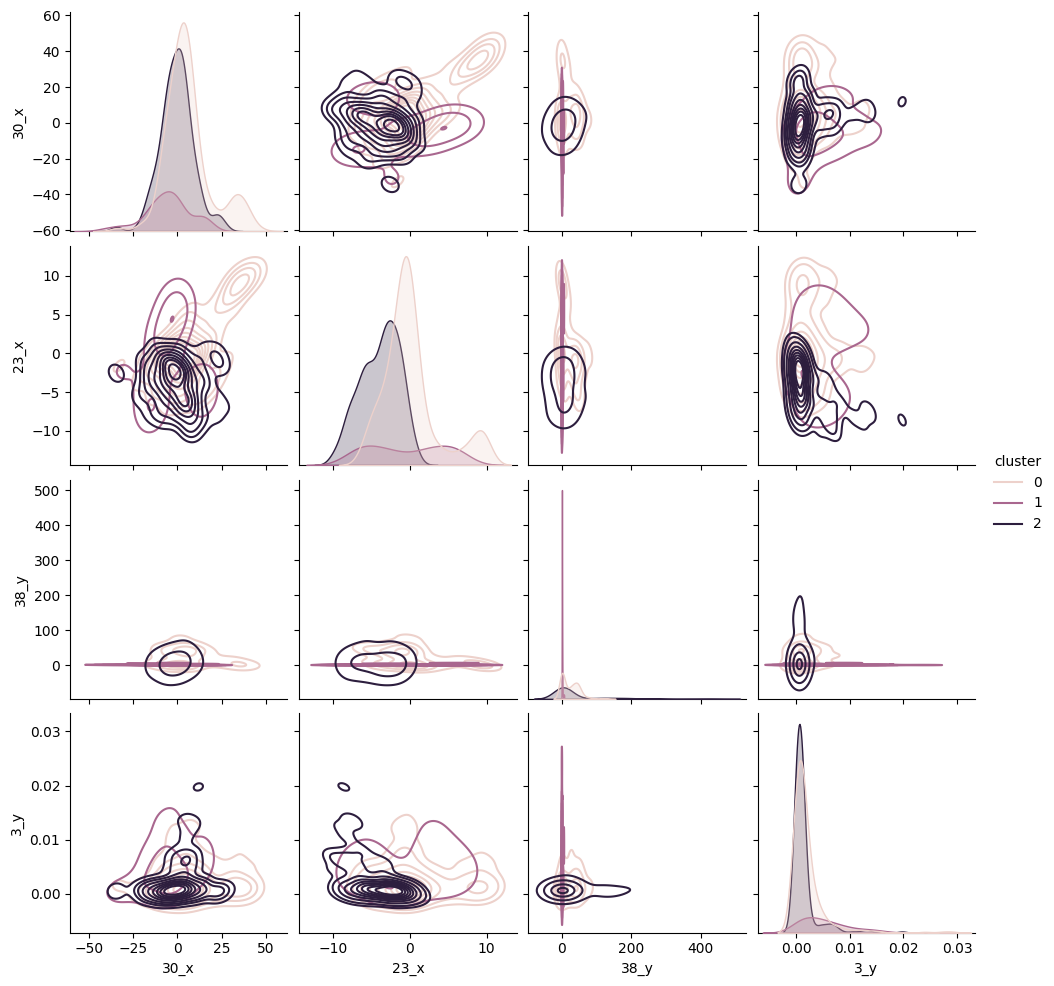

In [31]:
selected_columns = ['cluster', '30_x','23_x','38_y','3_y']
pamap_copy = pamap[selected_columns].copy()


# pamap_copy = pamap_copy.rename(columns=column_mapping)
sns.pairplot(pamap_copy,hue='cluster',kind='kde') 
